# HomeWork 12

**DeadLine : 23:59 27 Azar 1399**

**Total points : 100pts**

Import some prerequisites:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from skimage.feature import local_binary_pattern
from skimage.feature import hog
import pandas as pd
import seaborn as sn
import os
import time

Run this cell for plotting.

In [2]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

Run this cell for plotting evaluation.

In [3]:
from sklearn.metrics import accuracy_score,confusion_matrix
def evaluation(y_test, y_pred, fig_name, title):
    '''
    Prints accuracy and plots confusion matrix and saves result image.

    Parameters:
        y_test (numpy.ndarray) : test labels (ground truth)
        y_pred (numpy.ndarray) : predicted labels 
        fig_name (str): The name of the image of the plot.
        title (str): The caption of the plot.
    '''

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print('Accuracy for', title, '=', acc * 100)
    df_cm = pd.DataFrame(cm, range(10), range(10))
    plt.figure(figsize = (10, 7))
    sn.set(font_scale = 1.4) # for label size
    sn.heatmap(df_cm , annot = True, annot_kws = {"size" : 16}, fmt = 'g') # font size
    plt.title(title)
    plt.savefig(fig_name + '.png')
    plt.show()

# PART 3

Here is for your helper functions(optional)

In [110]:
def extract_shape_desc(x):
    _,thresh = cv2.threshold(x,170,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    cnt = biggest_contour

    leftmost = np.array(cnt[cnt[:,:,0].argmin()][0]).reshape(2,1)
    rightmost = np.array(cnt[cnt[:,:,0].argmax()][0]).reshape(2,1)
    topmost = np.array(cnt[cnt[:,:,1].argmin()][0]).reshape(2,1)
    bottommost = np.array(cnt[cnt[:,:,1].argmax()][0]).reshape(2,1)
    
    area = cv2.contourArea(cnt)
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = float(area)/(hull_area+1e-7)
    
    x,y,w,h = cv2.boundingRect(cnt)
    aspect_ratio = float(w)/h

    return np.concatenate((leftmost,rightmost,
                          topmost,bottommost,[[solidity],[aspect_ratio]]),axis=0)

Classify images with HOG.

In [5]:
def classify_hog(x_train, y_train, x_test):
    '''
    Classifies images with HOG.
    
    Parameters:
        x_train(numpy.ndarray) : train data
        y_train(numpy.ndarray) : train labels
        x_test(numpy.ndarray) : test data
        
    outputs:
        predicted_labels(numpy.ndarray): labels that predicted
    '''
    
    x_t = x_train.copy()
    y_t = y_train.copy()
    x_te = x_test.copy()
    predicted_labels = None
    
    hog_image = np.array([hog(x, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(3, 3), visualize=True,
                        multichannel=False)[0] for x in x_train])
    
    hog_image_test = np.array([hog(x, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(3, 3), visualize=True,
                        multichannel=False)[0] for x in x_test])
    svm = LinearSVC()
    svm.fit(hog_image,y_train)
    predicted_labels = svm.predict(hog_image_test)
    return predicted_labels    

Classify images using shape descriptors.

In [17]:
def classify_shape_desc(x_train, y_train, x_test):
    '''
    Classifies images by using shape descriptors.
    
    Parameters:
        x_train(numpy.ndarray) : train data
        y_train(numpy.ndarray) : train labels
        x_test(numpy.ndarray) : test data
        
    outputs:
        predicted_labels(numpy.ndarray): labels that predicted
    '''
    
    x_t = x_train.copy()
    y_t = y_train.copy()
    x_te = x_test.copy()
    predicted_labels = None
    
    data = np.squeeze([extract_shape_desc(x) for x in x_train])
    test = np.squeeze([extract_shape_desc(x) for x in x_test])

    svm = LinearSVC()
    svm.fit(data,y_train)
    predicted_labels = svm.predict(test)
    
    return predicted_labels    

Implement LBP here:

In [18]:
def LBP(img):
    '''
    Extracts LBP features from the input image.
    
    Parameters:
        img(numpy.ndarray) : image data
    outputs:
        output: LBP features
    '''
    R,C = img.shape
    multip_matrix = np.matrix([[1, 2, 4], [128, 0,8],[64,32,16]])
    transformed = np.zeros((26, 26))
    for i in range (1,R-1):
        for k in range (1,C-1):
            
            binary_matrix = np.zeros((3, 3))
            sub_mat = img[i-1:i+2,k-1:k+2]
            mid = sub_mat[1,1]
            higher = np.where(sub_mat > mid)
            lower = np.where(sub_mat <= mid)
            binary_matrix[higher] = 1
            binary_matrix[lower] = 0
            transformed[i-1,k-1] = np.sum(np.multiply(multip_matrix,binary_matrix))  
    
    hist, _ = np.histogram(transformed, bins=256, density=True, range=(0, 256))
    
    return hist

Classify images using your LBP.

In [9]:
def classify_your_lbp(x_train, y_train, x_test):
    '''
    Classifies images by using your LBP.
    
    Parameters:
        x_train(numpy.ndarray) : train data
        y_train(numpy.ndarray) : train labels
        x_test(numpy.ndarray) : test data
        
    outputs:
        predicted_labels(numpy.ndarray): labels that predicted
    '''
    data = [LBP(x) for x in x_train]
    test = [LBP(x) for x in x_test]
    
    data = np.array(data)
    test = np.array(test)
    svm = LinearSVC()
    svm.fit(data,y_train)
    predicted_labels = svm.predict(test)
    
    return predicted_labels    

Classify images using Scikit-Image LBP.

In [10]:
def classify_skimage_lbp(x_train, y_train, x_test):
    '''
    Classifies images by using Scikit-Image LBP.
    
    Parameters:
        x_train(numpy.ndarray) : train data
        y_train(numpy.ndarray) : train labels
        x_test(numpy.ndarray) : test data
        
    outputs:
        predicted_labels(numpy.ndarray): labels that predicted
    '''

    data = [np.histogram(local_binary_pattern(x,8,1), density=True
                         , bins=256, range=(0, 256))[0] for x in x_train]
    test = [np.histogram(local_binary_pattern(x,8,1), density=True
                         , bins=256, range=(0, 256))[0] for x in x_test]
    data = np.array(data)
    test = np.array(test)
    svm = LinearSVC()
    svm.fit(data,y_train)
    predicted_labels = svm.predict(test)
    
    return predicted_labels    

Test your implementation (don't change this cell).

In [11]:
data = np.load('mnist.npz')
[x_train, y_train, x_test, y_test] = data['x_train'], data['y_train'], data['x_test'], data['y_test']

Accuracy for using HOG = 93.7


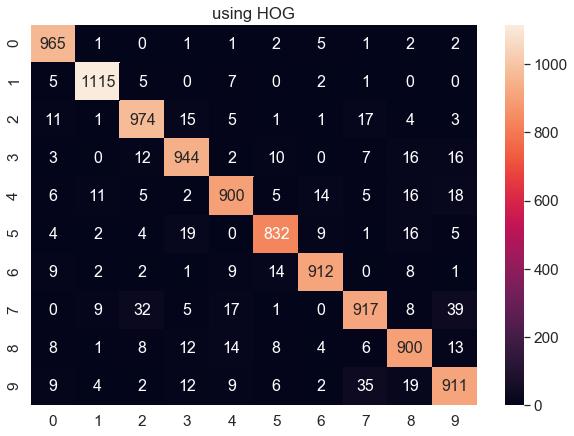

In [11]:
y_pred = classify_hog(x_train, y_train, x_test)
evaluation(y_test, y_pred, '3a', 'using HOG')

(60000, 10)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy for using shape descriptots = 59.18


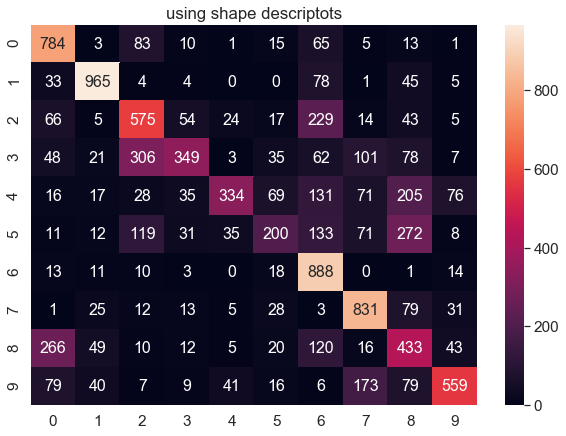

In [112]:
data = np.load('mnist.npz')
[x_train, y_train, x_test, y_test] = data['x_train'], data['y_train'], data['x_test'], data['y_test']
y_pred = classify_shape_desc(x_train, y_train, x_test)
evaluation(y_test, y_pred, '3b', 'using shape descriptots')

time for your LBP: 1789.097545 s
Accuracy for using your LBP = 70.61


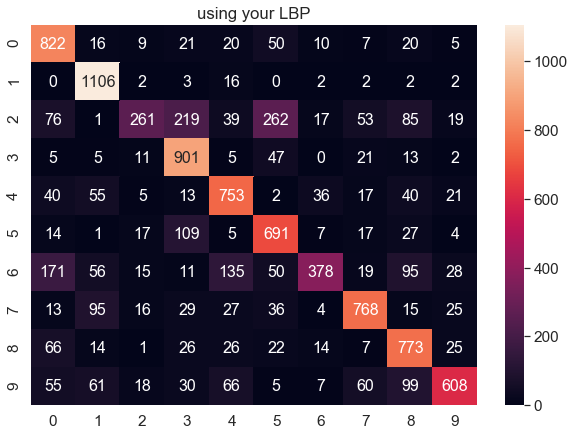

In [113]:
data = np.load('mnist.npz')
[x_train, y_train, x_test, y_test] = data['x_train'], data['y_train'], data['x_test'], data['y_test']
t1 = time.time()
y_pred = classify_your_lbp(x_train, y_train, x_test)
t2 = time.time()
print('time for your LBP: %f s' % (t2 - t1))
evaluation(y_test, y_pred, '3c', 'using your LBP')

time for Scikit-Image LBP: 37.060373 s
Accuracy for using Scikit-Image LBP = 57.07


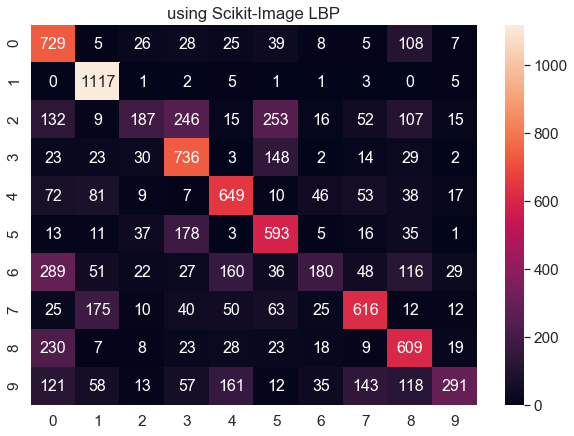

In [114]:
data = np.load('mnist.npz')
[x_train, y_train, x_test, y_test] = data['x_train'], data['y_train'], data['x_test'], data['y_test']
t1 = time.time()
y_pred = classify_skimage_lbp(x_train, y_train, x_test)
t2 = time.time()
print('time for Scikit-Image LBP: %f s' % (t2 - t1))
evaluation(y_test, y_pred, '3d', 'using Scikit-Image LBP')

In [ ]:
data = np.load('mnist.npz')
[x_train, y_train, x_test, y_test] = data['x_train'], data['y_train'], data['x_test'], data['y_test']
y_pred = classify_hog(x_train, y_train, x_test)
evaluation(y_test, y_pred, '3a', 'using HOG')
y_pred = classify_shape_desc(x_train, y_train, x_test)
evaluation(y_test, y_pred, '3b', 'using shape descriptots')
# t1 = time.time()
# y_pred = classify_your_lbp(x_train, y_train, x_test)
# t2 = time.time()
# print('time for your LBP: %f s' % (t2 - t1))
# evaluation(y_test, y_pred, '3c', 'using your LBP')
# t1 = time.time()
# y_pred = classify_skimage_lbp(x_train, y_train, x_test)
# t2 = time.time()
# print('time for Scikit-Image LBP: %f s' % (t2 - t1))
# evaluation(y_test, y_pred, '3d', 'using Scikit-Image LBP')

# PART 4

#### Use shape and geometrical features to classify two kinds of leaves.

Here is for your helper functions(optional)

Implement your code here.

In [4]:
def classify_leaf(image):
    '''
    Classifies the input image to only two classes of leaves.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        int: The class of the image. 1 == apple, 0 == linden
    '''
    # apple = 0
    # linden = 1
    leaf_type = 0
    
    #Write your code here
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    ret,thresh = cv2.threshold(gray,220,255,cv2.THRESH_BINARY_INV)
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    cnt = biggest_contour
    
    area = cv2.contourArea(cnt)
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = float(area)/(hull_area)
    
    x,y,w,h = cv2.boundingRect(cnt)
    aspect_ratio = float(w)/h
    
    area = cv2.contourArea(cnt)
    x,y,w,h = cv2.boundingRect(cnt)
    rect_area = w*h
    extent = float(area)/rect_area
    
    cv2.drawContours(image, [hull], -1, (0,255,0), 3)

    if solidity <= 0.875:
        if aspect_ratio >= 0.75:
            return 0
        else:
            if extent <= 0.6:
                return 0
            else:
                return 1
    else:
        if aspect_ratio <= 0.75:
            return 1
        else:
            if extent <= 0.6:
                return 1
            else:
                return 0
    
    return leaf_type

Test your implementation (don't change this cell).

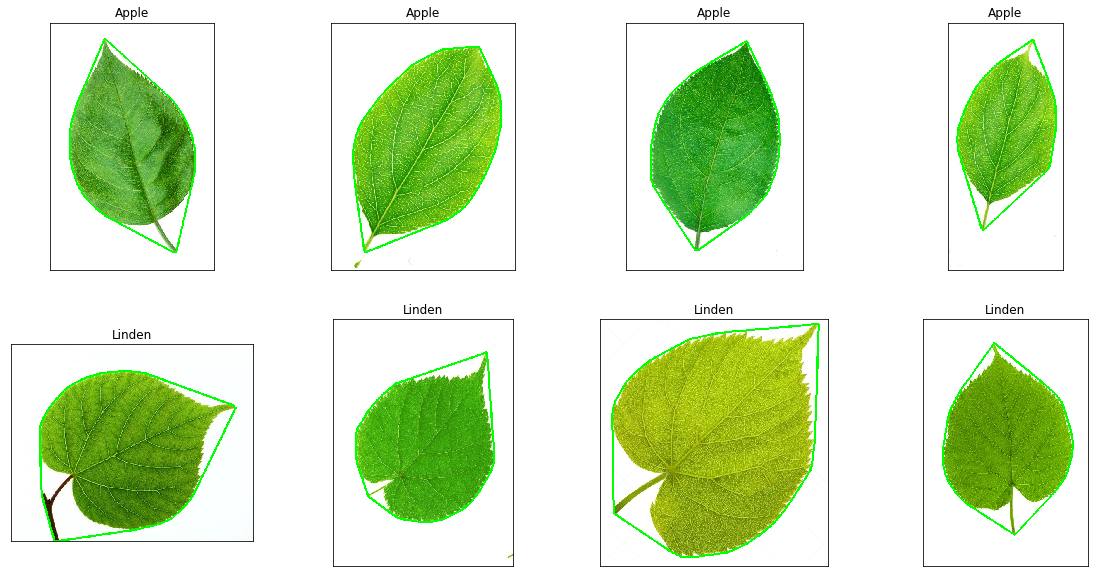

Accuracy is 0.0%


In [6]:
image_list = []
error = 0
for i in range(1,5):
    image = cv2.imread(os.path.join('images', 'apple', '{}.jpg'.format(i)))
    leaf_type = classify_leaf(image)
    error += int(leaf_type==1) 
    image_list.append([cv2.cvtColor(image, cv2.COLOR_BGR2RGB),'Apple' if leaf_type else 'Linden' , 'img'])
for i in range(1,5):
    image = cv2.imread(os.path.join('images', 'linden', '{}.jpg'.format(i)))
    leaf_type = classify_leaf(image)
    error += int(leaf_type==0)
    image_list.append([cv2.cvtColor(image, cv2.COLOR_BGR2RGB),'Apple' if leaf_type else 'Linden' , 'img'])
plotter(image_list, 2, 4, True, 20, 10, '4')
print("Accuracy is {}%".format(100-error/0.08))

To create proper files for sending in the Quera run this cell, please.

In [7]:
!python notebook_converter.py

End!!!